In [1]:
import captum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib.patches import Rectangle
from os import path
from skimage import io
from torch.nn import Linear
from torch.utils.data import Dataset
from torchvision.models import mnasnet0_5
from captum.attr import visualization

In [2]:
def show_image_bbox(image, bboxes: pd.DataFrame, ax=None):
    if ax is not None:
        ax.imshow(image)
    else:
        plt.imshow(image)
        ax = plt.gca()
    for idx, bbox in bboxes.iterrows():
        x = (bbox[0] - bbox[2] / 2) * 512
        y = (bbox[1] - bbox[3] / 2) * 512

        rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)
        
        
class CropWeedDataset(Dataset):
    
    def __init__(self, labels_csv, images_dir, transform=None):
        self.labels_frame = pd.read_csv(labels_csv, index_col=0)
        self.grouped_labels_frame = self.labels_frame.groupby('filename').sum("label")
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.grouped_labels_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = path.join(self.images_dir,
                                self.get_filename(idx))
        image = io.imread(img_name)
        label = int(self.grouped_labels_frame.iloc[idx, 0] > 0)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_bbox(self, idx):
        bbox = self.labels_frame.loc[self.labels_frame['filename'] == self.grouped_labels_frame.iloc[idx].name].iloc[:,2:6]
        return bbox
    
    def get_filename(self, idx):
        return self.grouped_labels_frame.iloc[idx].name
    
    def show_image(self, idx, ax=None):
        sample = self[idx]
        bbox = self.get_bbox(idx)

        if self.transform:
            numpy_image = sample['image'].numpy().transpose(1, 2, 0)
        else:
            numpy_image = sample['image']

        show_image_bbox(numpy_image, bbox, ax)


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) / 255,
                'label': torch.asarray(label)}
    
dataset = CropWeedDataset(labels_csv=path.join('..', '..', 'input', 'inz-data-prep', 'easy_labels_and_data.csv'),
                          images_dir=path.join('..', '..', 'input','crop-and-weed-detection-data-with-bounding-boxes','agri_data', 'data'),
                          transform=ToTensor())

In [3]:
model = mnasnet0_5()
model.classifier[1] = Linear(1280, 2)
model.load_state_dict(torch.load(path.join('..', 'models', 'mnasnet0_5'), map_location=torch.device('cpu')))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [4]:
explanations_dir = path.join('..', '..', 'input', 'crop-and-weed-explanations')

## Metrics for input (`Captum`) explanations

In [13]:
df = pd.DataFrame()
for i in range(16):
    df = pd.concat([df,pd.read_csv(path.join('..','..','input', 'sesame_metrics', 'input_explanations_{i}.csv'.format(i=i)), index_col=0)], axis=0)
    
df = df.groupby(by=df.index).mean()

In [14]:
df

,DIR0.0,CIR Same0.0,CIR Max0.0,Average Recall0.0,Average Precision0.0,F1_score0.0,IOU0.0,DIR0.1,CIR Same0.1,CIR Max0.1,...,Average Precision0.8,F1_score0.8,IOU0.8,DIR0.9,CIR Same0.9,CIR Max0.9,Average Recall0.9,Average Precision0.9,F1_score0.9,IOU0.9
Gradients,0.46875,0.092362,-0.049253,1.0,0.549989,0.677500,0.549989,0.46875,0.092265,-0.049350,...,0.031250,0.0,6.162508e-07,0.0,-0.000018,-0.000018,2.742498e-08,0.015625,0.0,2.742498e-08
Lime,0.46875,0.092362,-0.049253,1.0,0.550162,0.677637,0.550162,0.46875,0.093056,-0.048559,...,0.014078,0.0,1.985684e-03,0.0,0.000689,0.000689,2.013803e-03,0.014078,0.0,1.985684e-03
Saliency,0.46875,0.092362,-0.049253,1.0,0.549989,0.677500,0.549989,0.03125,-0.003744,-0.004257,...,0.062500,0.0,6.670312e-07,0.0,-0.000031,-0.000031,2.482483e-07,0.062500,0.0,2.482483e-07


In [43]:
def plot_results(df):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,10), sharex=True)
    for idx, metric in enumerate(["DIR", "CIR Same", "CIR Max", "Average Recall", "Average Precision", "F1_score", "IOU"]):
        metric_df = df.loc[:, [metric in i for i in df.columns]]
        metric_df.columns = [i/10 for i in range(10)]
        metric_df.transpose().plot(title=metric, xlabel='threshold', ax=ax[idx%2][idx//2], legend=False)
        if idx == 6:
            h, l = ax[idx%2][idx//2].get_legend_handles_labels()

    ax[1][3].legend(h, l, loc='upper left', fontsize='xx-large', frameon=False, markerscale=2)
    ax[1][3].set_axis_off()

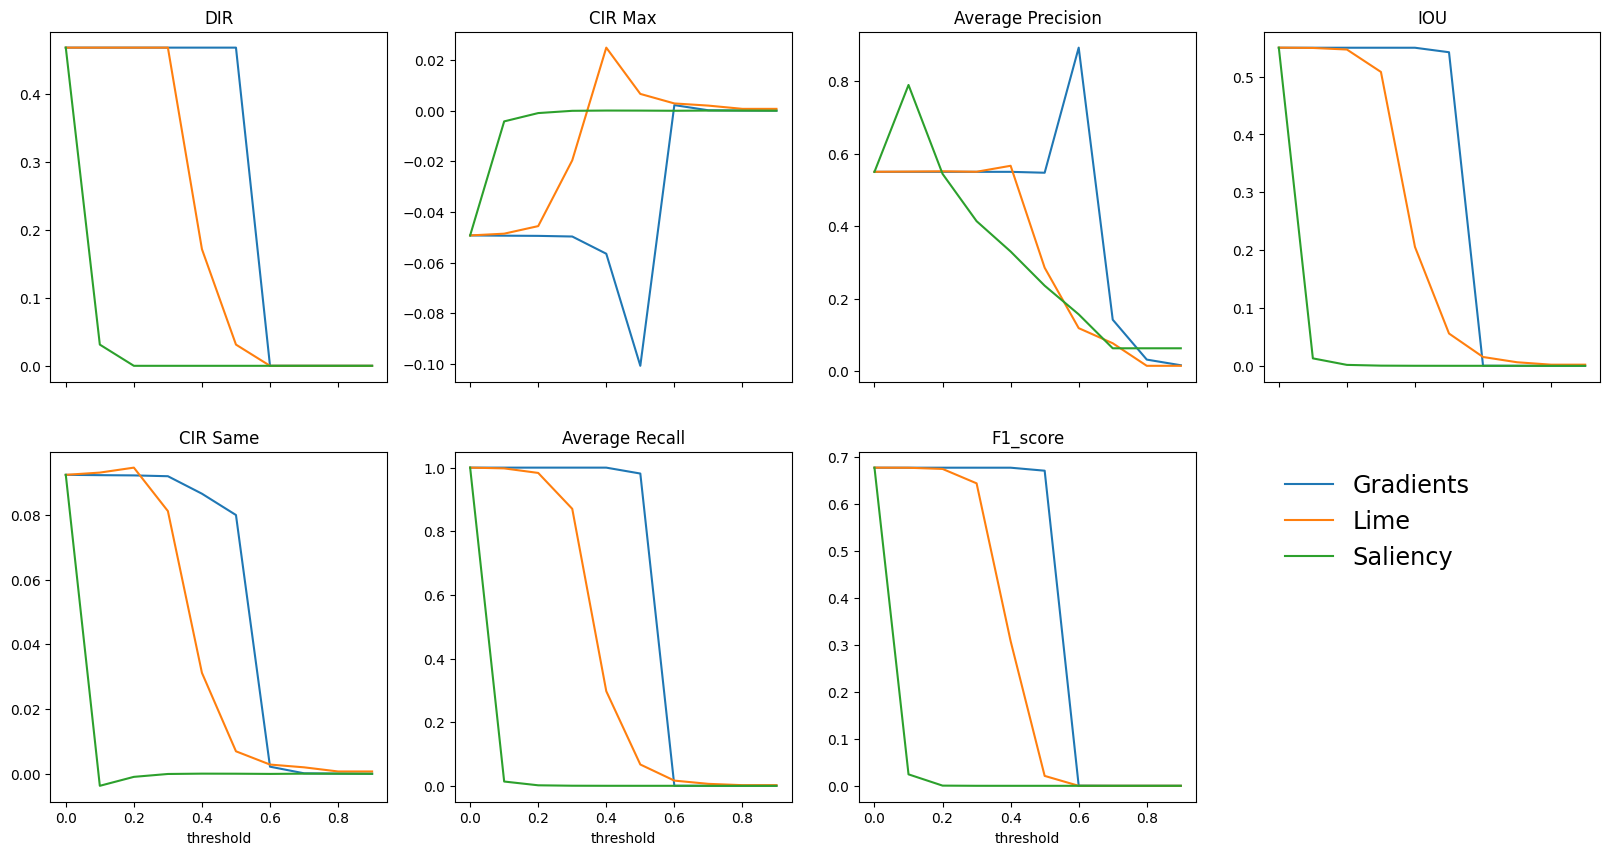

In [44]:
plot_results(df)

## Metrics for aggregates

In [45]:
df = pd.DataFrame()
for i in range(16):
    df = pd.concat([df,pd.read_csv(path.join('..','..','input', 'sesame_metrics', 'agg_explanations_{i}.csv'.format(i=i)), index_col=0)], axis=0)
    
df = df.groupby(by=df.index).mean()

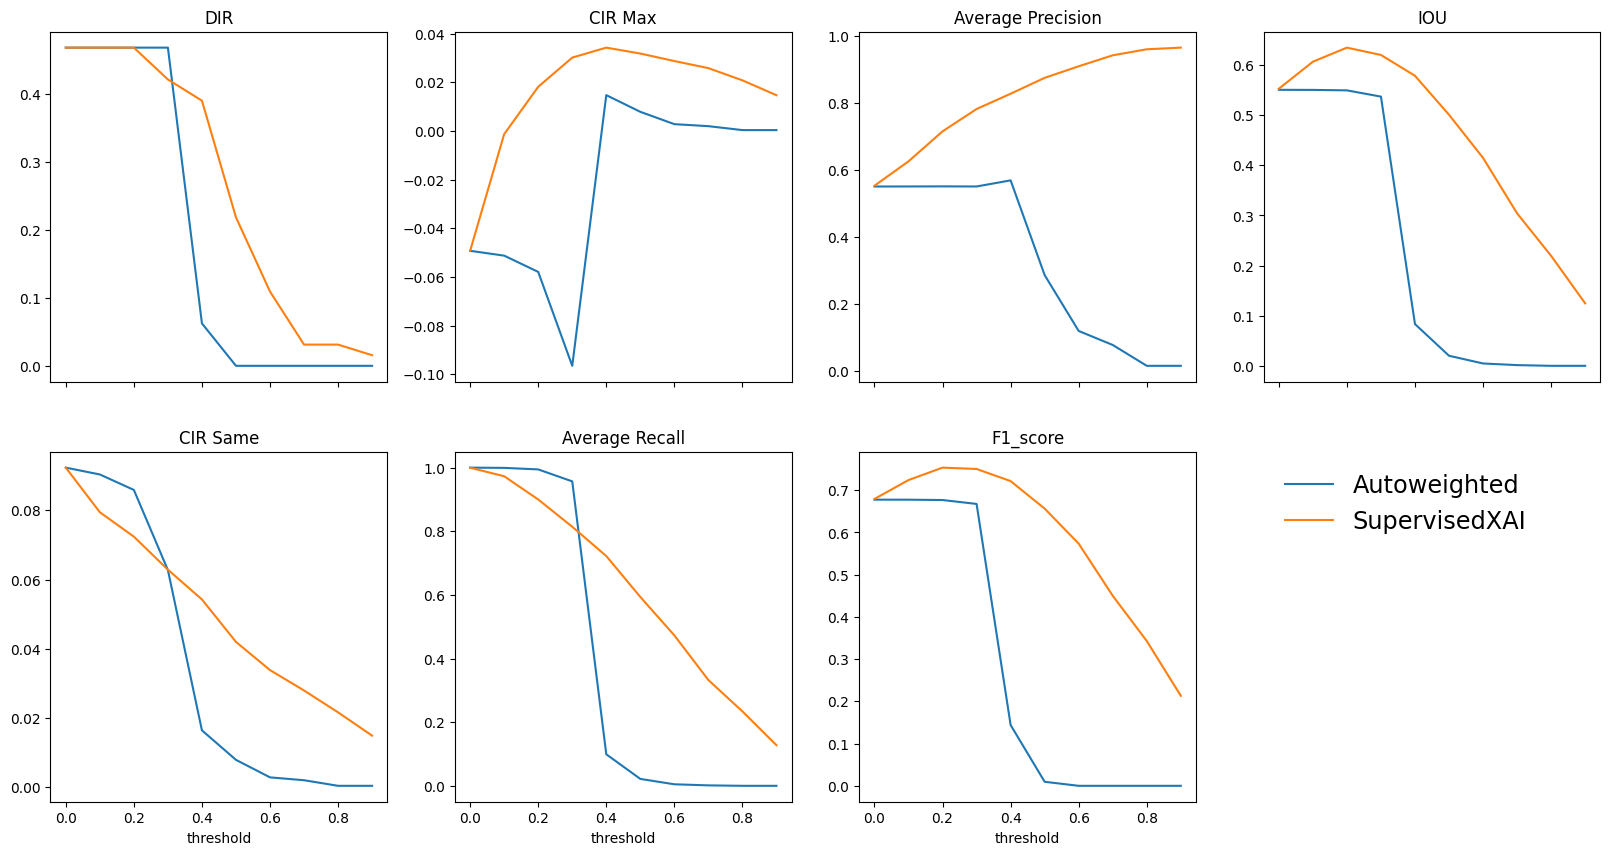

In [46]:
plot_results(df)